In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import lightning as L
import torch
import torch.nn as nn
import torch.nn.functional as F
import yfinance as yf

import logging

# configure logging at the root level of Lightning
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

%matplotlib inline
%load_ext tensorboard
sns.set_theme()

# Settings

In [3]:
train_size = 0.8 # train/test split
subsample = False # whether to randomly subsample the training data
subsample_size = 0.1 # fraction of training data to keep

# list of stock tickers to use, top 3 from S&P 500 sector by market cap
stock_tickers = ["META", "GOOGL", "NFLX", "AMZN", "TSLA", "HD", "PG", "COST", "PEP", "XOM", "CVX", "COP", "MA", "JPM", "V", "UNH", "JNJ", "LLY", "UNP", "BA", "CAT", "LIN", "SHW", "FCX", "PLD", "AMT", "EQIX", "MSFT", "AAPL", "AVGO", "NEE", "SO", "DUK"]
# stock_tickers = pd.read_csv("../data/sp500-firms.csv")["Symbol"].values.tolist()

lookback_window = 60 # num of days to look back
lookahead_window = 1 # num of days to look ahead

input_size = 2 # num feature channels (price, volume, sentiment, etc)
num_layers = 2 # num of stacked LSTM layers
hidden_size = 128 # num of nodes per LSTM layer
output_size = lookahead_window # lookahaed window size

max_epochs = 80 # max num of epochs to train for per ticker
learning_rate = 1e-4 # learning rate

# Dataset Preparation

In [4]:
import pickle as pkl

with open("../data/final/sp500-price-volume.pkl", "rb") as f:
    sp500_df = pkl.load(f)

with open("../data/final/sp500-price-volume-sentiment.pkl", "rb") as f:
    sp500_sentiment_df = pkl.load(f)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
def split_data(df: pd.DataFrame,
               train_size: float = 0.8,
               lbp: int = 30,
               lfp: int = 1) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    """
    lbp: look back period
    lfp: look forward period
    """
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    tickers = df["Ticker"].unique()

    for ticker in tickers:
        ticker_df = df[df["Ticker"] == ticker]
        ticker_df = ticker_df.drop("Ticker", axis=1)
        ticker_df = ticker_df.set_index("Date")
        ticker_array = ticker_df.sort_index().values
        
        train_count = int(ticker_array.shape[0] * train_size)
        train = ticker_array[:train_count]
        test = ticker_array[train_count:]

        ticker_X_train = []
        ticker_y_train = []
        ticker_X_test = []
        ticker_y_test = []


        for i in range(lbp, train.shape[0] - lfp + 1):
            ticker_X_train.append(train[i - lbp:i, :])
            ticker_y_train.append(train[i:i + lfp, 0])
        
        for i in range(lbp, test.shape[0] - lfp + 1):
            ticker_X_test.append(test[i - lbp:i, :])
            ticker_y_test.append(test[i:i + lfp, 0])

        X_train.append(ticker_X_train)
        y_train.append(ticker_y_train)
        X_test.append(ticker_X_test)
        y_test.append(ticker_y_test)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    X_train = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape[0] * X_train.shape[1], X_train.shape[2], -1)
    X_test = X_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2], -1)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape[0] * y_train.shape[1], y_train.shape[2])
    y_test = y_scaler.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape[0] * y_test.shape[1], y_test.shape[2])

    return X_train, y_train, X_test, y_test, y_scaler

(X_train_no_sentiment, y_train_no_sentiment, X_test_no_sentiment, y_test_no_sentiment, y_scaler_no_sentiment) = split_data(sp500_df, train_size=train_size, lbp=lookback_window, lfp=lookahead_window)
(X_train_sentiment, y_train_sentiment, X_test_sentiment, y_test_sentiment, y_scaler_sentiment) = split_data(sp500_sentiment_df, train_size=train_size, lbp=lookback_window, lfp=lookahead_window)

print(f"X_train_no_sentiment shape: {X_train_no_sentiment.shape}")
print(f"y_train_no_sentiment shape: {y_train_no_sentiment.shape}")
print(f"X_test_no_sentiment shape: {X_test_no_sentiment.shape}")
print(f"y_test_no_sentiment shape: {y_test_no_sentiment.shape}")
print()
print(f"X_train_sentiment shape: {X_train_sentiment.shape}")
print(f"y_train_sentiment shape: {y_train_sentiment.shape}")
print(f"X_test_sentiment shape: {X_test_sentiment.shape}")
print(f"y_test_sentiment shape: {y_test_sentiment.shape}")

X_train_no_sentiment shape: (64482, 60, 2)
y_train_no_sentiment shape: (64482, 1)
X_test_no_sentiment shape: (14652, 60, 2)
y_test_no_sentiment shape: (14652, 1)

X_train_sentiment shape: (64482, 60, 3)
y_train_sentiment shape: (64482, 1)
X_test_sentiment shape: (14652, 60, 3)
y_test_sentiment shape: (14652, 1)


# Model Training

In [8]:
from sklearn.linear_model import LinearRegression

X_train_sentiment = X_train_sentiment.reshape(X_train_sentiment.shape[0], -1)
X_test_sentiment = X_test_sentiment.reshape(X_test_sentiment.shape[0], -1)
X_train_no_sentiment = X_train_no_sentiment.reshape(X_train_no_sentiment.shape[0], -1)
X_test_no_sentiment = X_test_no_sentiment.reshape(X_test_no_sentiment.shape[0], -1)

lr_sentiment = LinearRegression()
lr_no_sentiment = LinearRegression()

lr_sentiment.fit(X_train_sentiment, y_train_sentiment)
lr_no_sentiment.fit(X_train_no_sentiment, y_train_no_sentiment)

LinearRegression()

In [22]:
y_test_no_sentiment = y_test_no_sentiment.reshape(-1)
y_test_sentiment = y_test_sentiment.reshape(-1)

y_hat_no_sentiment = lr_no_sentiment.predict(X_test_no_sentiment).reshape(-1)
y_hat_sentiment = lr_sentiment.predict(X_test_sentiment).reshape(-1)

## Predictions

[*********************100%%**********************]  1 of 1 completed
RMSE: 0.125
N = 444


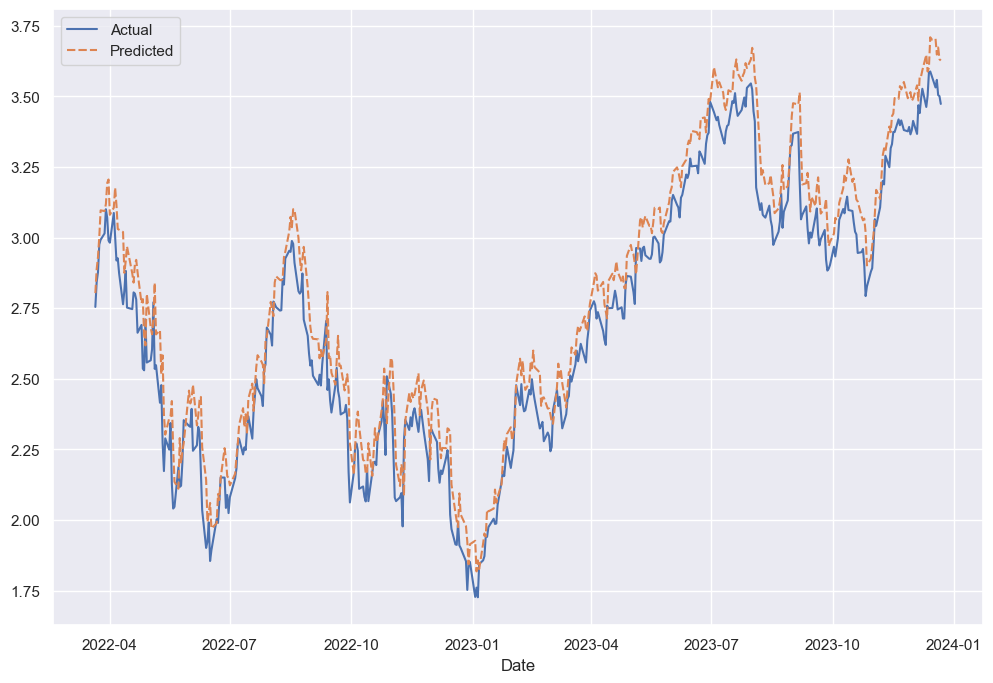

In [52]:
test_ticker = "AAPL"
df = sp500_df

test_download = yf.download(
    tickers=[test_ticker],
    period="10y",
    interval="1d",
)


_, _, X_test, y_test, _ = split_data(df[df["Ticker"] == test_ticker], train_size=train_size, lbp=lookback_window, lfp=lookahead_window)

y_hat = lr_no_sentiment.predict(X_test.reshape(X_test.shape[0], -1)).reshape(-1)
y_test = y_test.reshape(-1)

df_plot = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_hat,
}, index=df["Date"][-len(y_test):])

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(df_plot, ax=ax)
print(f"RMSE: {np.sqrt(np.mean((y_hat - y_test) ** 2)):.3f}")
print(f"N = {len(y_test)}")

## Statistical Testing

(-0.25, 0.25)

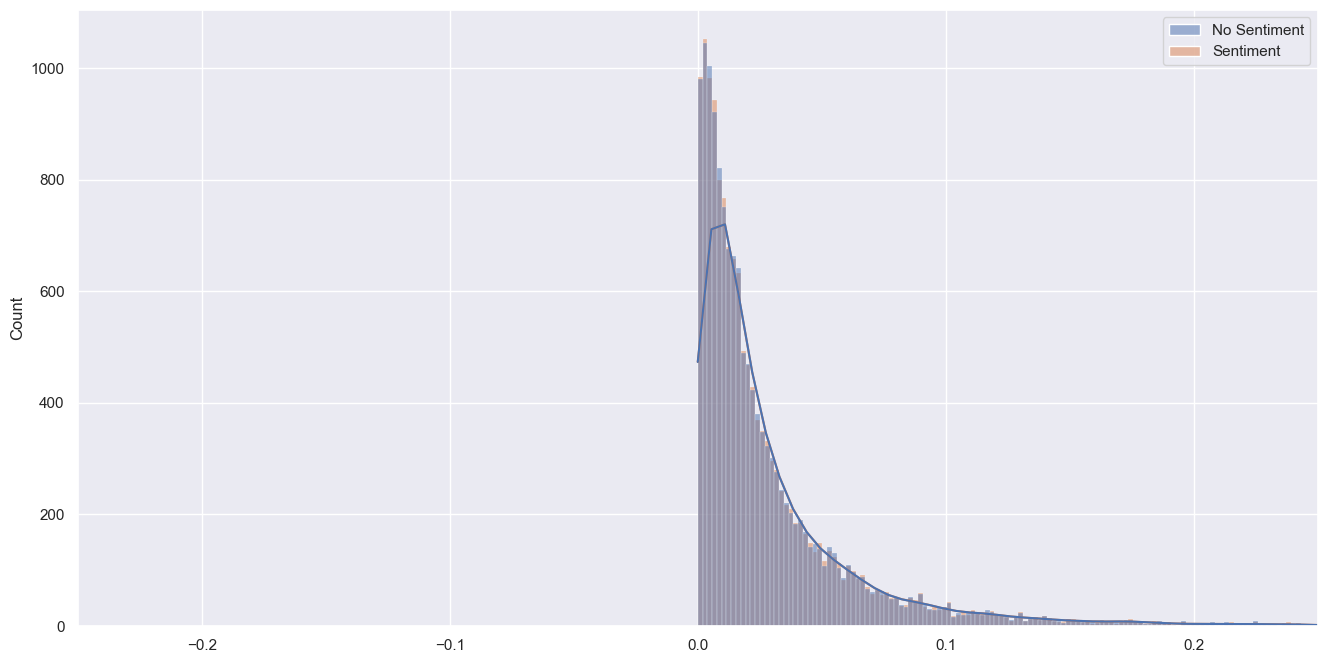

In [46]:
# hist of residuals
res_no_sentiment = np.sqrt((y_test_no_sentiment - y_hat_no_sentiment) ** 2)
res_sentiment = np.sqrt((y_test_sentiment - y_hat_sentiment) ** 2)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

df_residuals = pd.DataFrame({
    "No Sentiment": res_no_sentiment,
    "Sentiment": res_sentiment
})

sns.histplot(data=df_residuals, ax=ax, kde=True)
ax.set_xlim(-0.25, 0.25)

In [47]:
from scipy.stats import shapiro

shapiro(res_no_sentiment - res_sentiment)

/Users/pranav/Projects/cos497/venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.8762325048446655, pvalue=0.0)

In [48]:
y_hat_diff = res_no_sentiment - res_sentiment

diff_mean = y_hat_diff.mean()
diff_std = y_hat_diff.std()
diff_n = y_hat_diff.shape[0]
diff_se = diff_std / np.sqrt(diff_n)
t_stat = diff_mean / diff_se

print(f"Mean of differences: {diff_mean:.3f}")
print(f"Std of differences: {diff_std:.3f}")
print(f"N: {diff_n} (df = {diff_n - 1})")
print(f"Standard Error: {diff_se:.3f}")
print(f"t-stat: {t_stat:.3f}")

Mean of differences: -0.000
Std of differences: 0.000
N: 14652 (df = 14651)
Standard Error: 0.000
t-stat: -1.900


In [49]:
from scipy.stats import ttest_rel

ttest_rel(res_no_sentiment, res_sentiment, alternative="two-sided")

TtestResult(statistic=-1.8999416116262713, pvalue=0.057460397419317556, df=14651)